# Backward Projection

The example explains how to use EasyIDP to find the corresponding position of ROI on the origial UAV images.

## Package and data prepare

The most common way to import easyidp package is:

In [1]:
import easyidp as idp

lotus = idp.data.Lotus()

If you run for the first time, it will download 3.3GB dataset automatically from Google Drive, please refer to [Data](../python_api/data.rst) for more details.

## Read ROI from Shapefile

Then open the shapefile `plot.shp`, the shp file looks like (red polygons):


<center><img src="../_static/images/data/2017_tanashi_lotus.png" alt="lotus plot" width="61%"/></center>

In [2]:
roi = idp.ROI(lotus.shp, name_field='plot_id')

[shp][proj] Use projection [WGS 84] for loaded shapefile [plots.shp]


Read shapefile [plots.shp]: 100%|██████████| 112/112 [00:00<00:00, 1675.52it/s]


Then check if it loads as expected:

In [3]:
roi

<easyidp.ROI> with 112 items
[0]	N1W1
array([[139.54052962,  35.73475194],
       [139.54055106,  35.73475596],
       [139.54055592,  35.73473843],
       [139.54053438,  35.73473446],
       [139.54052962,  35.73475194]])
[1]	N1W2
array([[139.54053488,  35.73473289],
       [139.54055632,  35.73473691],
       [139.54056118,  35.73471937],
       [139.54053963,  35.73471541],
       [139.54053488,  35.73473289]])
...
[110]	S4E6
array([[139.54090456,  35.73453742],
       [139.540926  ,  35.73454144],
       [139.54093086,  35.7345239 ],
       [139.54090932,  35.73451994],
       [139.54090456,  35.73453742]])
[111]	S4E7
array([[139.54090986,  35.73451856],
       [139.54093129,  35.73452258],
       [139.54093616,  35.73450504],
       [139.54091461,  35.73450107],
       [139.54090986,  35.73451856]])

## Get height (z) values from DSM

The ROI from shapefile is only 2D coordinate, however, to do backward projection, the ROI should be 3D coordainte, the missing height values can be obtianed from DSM

<div class="alert alert-info">

Future work

Getting Z values from point cloud will be supported in the future, in this case, if only need backward projection (do image analyze on origial images instead of low quality geotiff), the 3D reconstuction can stop at making dense point cloud, no need to run the later DOM and DSM step.

</div>


In [4]:
roi.get_z_from_dsm(lotus.metashape.dsm)

Read z values of roi from DSM [170531.Lotus_dsm.tif]: 100%|██████████| 112/112 [00:01<00:00, 110.47it/s]


And check the values of ROI

In [5]:
roi

<easyidp.ROI> with 112 items
[0]	N1W1
array([[ 368017.7565143 , 3955511.08102276,      97.39836121],
       [ 368019.70190232, 3955511.49811902,      97.39836121],
       [ 368020.11263046, 3955509.54636219,      97.39836121],
       [ 368018.15769062, 3955509.13563382,      97.39836121],
       [ 368017.7565143 , 3955511.08102276,      97.39836121]])
[1]	N1W2
array([[ 368018.20042946, 3955508.96051697,      97.31330109],
       [ 368020.14581791, 3955509.37761334,      97.31330109],
       [ 368020.55654627, 3955507.42585654,      97.31330109],
       [ 368018.601606  , 3955507.01512806,      97.31330109],
       [ 368018.20042946, 3955508.96051697,      97.31330109]])
...
[110]	S4E6
array([[ 368051.31139629, 3955486.78103425,      97.61438751],
       [ 368053.25678767, 3955487.19813795,      97.61438751],
       [ 368053.66752456, 3955485.24638299,      97.61438751],
       [ 368051.71258131, 3955484.83564713,      97.61438751],
       [ 368051.31139629, 3955486.78103425,      97.61

We can notice, the roi x and y values also changed. Because the ROI shp geo-coord is EPSG::4326 while the DSM is EPSG::32654.

<div class="alert alert-info">

See also

For more details about the controls to this function, please refer to [Get Height(z) Values from DSM](get_z_from_dsm.ipynb)

</div>


## Read 3D reconstuction project and backward projection

For metashape project:

In [6]:
ms = idp.Metashape(lotus.metashape.project, chunk_id=0)

For pix4d project:

In [7]:
p4d = idp.Pix4D(project_path=lotus.pix4d.project, 
                raw_img_folder=lotus.photo,
                param_folder=lotus.pix4d.param)

And then do the backward projection by:

In [8]:
img_dict_ms = roi.back2raw(ms)
img_dict_p4d = roi.back2raw(p4d)

Backward roi to raw images: 100%|██████████| 112/112 [00:01<00:00, 84.48it/s]


or

```python
>>> img_dict_ms = ms.back2raw(roi)
>>> img_dict_p4d = p4d.back2raw(roi)
```

The structure of output `img_dict` is 2 layers dictionary. The first layer is roi id, the second layer is image name (`out_dict['roi_id']['image_name']`).

You can find all available images with specified roi (plot) (e.g. roi named 'N1W1') by:

```python
>>> img_dict_ms['N1W1'] 
{'DJI_0479': array([[  43.91987253, 1247.04066872],
                    [  69.0221046 ,  972.89938018],
                    [ 353.25370817,  993.30409359],
                    [ 328.10701394, 1267.40353364],
                    [  43.91987253, 1247.04066872]]),
 'DJI_0480': array([[ 655.3678591 , 1273.01418098],
                    [ 681.18303761,  996.4866665 ],
                    [ 965.60719523, 1019.55346144],
                    [ 939.89408896, 1296.05588162],
                    [ 655.3678591 , 1273.01418098]]),
...
}
```

For example, find the roi named 'N1W1' on image 'IMG_3457' by:

In [9]:
img_dict_ms["N1W1"]['DJI_0479']

array([[  43.91987253, 1247.04066872],
       [  69.0221046 ,  972.89938018],
       [ 353.25370817,  993.30409359],
       [ 328.10701394, 1267.40353364],
       [  43.91987253, 1247.04066872]])

This is the 2D coordinates that roi on the image pixels

The recommended 'for loops' for itering items:

```python
for roi_id, img_dict in out_dict.items():
    # roi_id = 'N1W1'
    # img_dict = out_dict[roi_id]
    for img_name, coords in img_dict.items():
        # img_name = "IMG_3457"
        # coords = out_dict[roi_id][img_name]
        print(coords)
```

Preview the results:

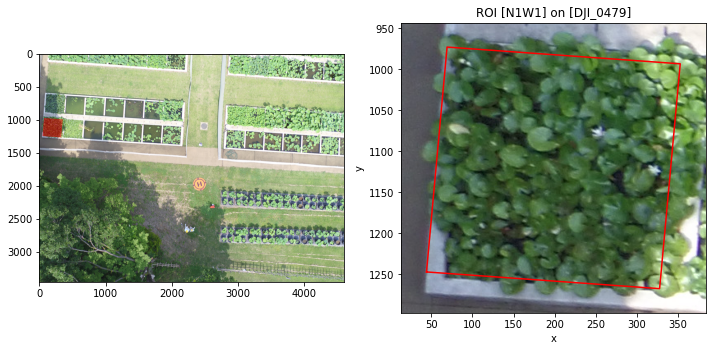

<Figure size 432x288 with 0 Axes>

In [10]:
ms.show_one_roi_on_img(img_dict_ms, "N1W1", "DJI_0479")

## Find the best backward image

You can notice that for each ROI, it will backword projected to several raw images:

In [11]:
len(img_dict_ms["N1W1"])

17

How to find the best 3 or 5 images? Here you can calculate the distance from the image to the ROI, here we assume the shorter the better (idealy, UAV image just above the ROI region, the ROI is in the image center).

In [12]:
img_dict_sort = ms.sort_img_by_distance(
    img_dict_ms, roi, 
    distance_thresh=10,  # distance threshold is 2m 
    num=3   # only keep 3 closest images
)

Filter by distance to ROI: 100%|██████████| 112/112 [00:00<00:00, 1443.04it/s]


In [13]:
img_dict_sort["N1W1"]

{'DJI_0500': array([[1922.56317403, 2186.55026212],
        [1931.87582434, 1925.40596027],
        [2192.1757749 , 1934.43920442],
        [2182.74834419, 2195.88054775],
        [1922.56317403, 2186.55026212]]),
 'DJI_0517': array([[2865.83794784, 2151.98114332],
        [2592.43855364, 2169.39562183],
        [2574.82262634, 1895.17496101],
        [2848.48455635, 1878.83422193],
        [2865.83794784, 2151.98114332]]),
 'DJI_0501': array([[1964.74098137, 1514.46208287],
        [1974.95313868, 1258.05047894],
        [2233.01889145, 1269.92769931],
        [2222.63045448, 1526.62893437],
        [1964.74098137, 1514.46208287]])}

Here is the best 3 image that match "distance from ROI to image" < 10m, and the first one is the closest.

Check the result:

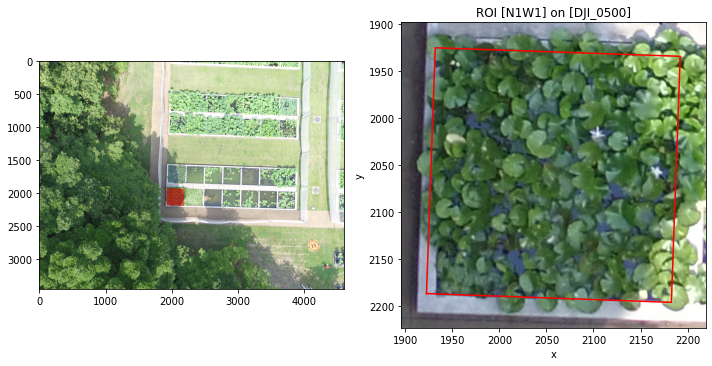

<Figure size 432x288 with 0 Axes>

In [14]:
ms.show_one_roi_on_img(img_dict_ms, "N1W1", "DJI_0500")